# WIDS Predict Hospital Fatality

**Table of Contents:**

1. Import Libriaries/packages
2. Explore Data
3. Preprocess data (missing values, collinearity (correlation), scale)
4. Model http://localhost:8888/lab#Convert-to-numerical-via-labelencoding-or-onehotencoding-#revisit
5. Evaluate


In [1]:
from datetime import datetime

# track start time
start_time = datetime.now()

In [3]:
# view input directory

import os
for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

./input\samplesubmission.csv
./input\solution_template.csv
./input\training_v2.csv
./input\unlabeled.csv
./input\WiDS Datathon 2020 Dictionary.csv


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.impute import SimpleImputer
import seaborn as sns # plotting library
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder



# additional experiement packages
import missingno as msno

%matplotlib inline

## Load Data

In [107]:
# loading dataset 

training = pd.read_csv("./input/training_v2.csv")
solution_template = pd.read_csv("./input/solution_template.csv")
samplesubmission = pd.read_csv("./input/samplesubmission.csv")
unlabeled = pd.read_csv("./input/unlabeled.csv")
dictionary = pd.read_csv("./input/WiDS Datathon 2020 Dictionary.csv")

In [108]:
# create a back up

training_backup = training.copy()

In [109]:
# view data

training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Columns: 186 entries, encounter_id to apache_2_bodysystem
dtypes: float64(170), int64(8), object(8)
memory usage: 130.1+ MB


In [110]:
solution_template.head()

,encounter_id,hospital_death
0,2,NaN
1,5,NaN
2,7,NaN
3,8,NaN
4,10,NaN


In [111]:
samplesubmission.head()

,encounter_id,hospital_death
0,2,0.500
1,5,0.200
2,7,0.001


In [112]:
unlabeled.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,2,127112,7,NaN,56.0,21.102439,0,Caucasian,M,180.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
1,5,130737,178,NaN,NaN,19.500595,1,Caucasian,F,145.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
2,7,101458,86,NaN,66.0,32.518596,1,African American,M,170.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
3,8,48067,163,NaN,64.0,20.798520,0,Caucasian,M,182.8,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Respiratory,Respiratory
4,10,25865,59,NaN,56.0,NaN,0,Caucasian,M,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic


In [113]:
unlabeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39308 entries, 0 to 39307
Columns: 186 entries, encounter_id to apache_2_bodysystem
dtypes: float64(171), int64(7), object(8)
memory usage: 55.8+ MB


In [114]:
dictionary.head()

,Category,Variable Name,Unit of Measure,Data Type,Description,Example
0,identifier,encounter_id,None,integer,Unique identifier associated with a patient un...,None
1,identifier,hospital_id,None,integer,Unique identifier associated with a hospital,None
2,identifier,patient_id,None,integer,Unique identifier associated with a patient,None
3,demographic,hospital_death,None,binary,Whether the patient died during this hospitali...,0
4,demographic,age,Years,numeric,The age of the patient on unit admission,None


## Explore Data:

1. One way plots (bar and dot plot)

In [115]:
training.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [116]:
x, y, hue = "index", "hospital_death", "sex"
hue_order = ["Male", "Female"]

(training.gender
 .value_counts(normalize=True)
 .rename({'gender': 'proportion'}, axis=0)
 )

M    0.539536
F    0.460464
Name: gender, dtype: float64

In [117]:
training['gender_missing'] = training.gender.copy()

In [118]:
training['gender_missing'] = training.gender_missing.fillna('Missing')

In [119]:
training.gender_missing.value_counts()

M          49469
F          42219
Missing       25
Name: gender_missing, dtype: int64

In [120]:
training['gender_missing'].value_counts(normalize=True)

M          0.539389
F          0.460338
Missing    0.000273
Name: gender_missing, dtype: float64

In [121]:
training.groupby('gender_missing').mean()['hospital_death']

gender_missing
F          0.088373
M          0.084417
Missing    0.320000
Name: hospital_death, dtype: float64

In [122]:
training.groupby('gender').mean()['hospital_death']

gender
F    0.088373
M    0.084417
Name: hospital_death, dtype: float64

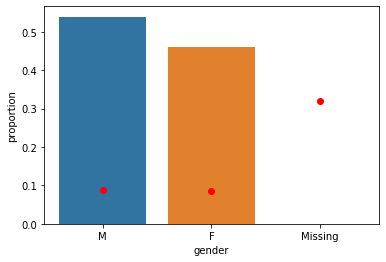

In [123]:
(training['gender_missing']
.value_counts(normalize=True)
.reset_index()
.rename(columns={'index': 'gender', 'gender_missing': 'proportion'})
.pipe((sns.barplot, 'data'), x='gender', y='proportion')
)

plt.plot(training.groupby('gender_missing').mean()['hospital_death'], 'ro')



### Calculate correlation matrix

In [124]:
%%time

corr_matrix = training.corr().abs

Wall time: 7.13 s


In [125]:
training_3 = training.copy()

In [126]:
training_3.drop(training_3.columns[training_3.apply(lambda col: col.isnull().sum() / training_3.shape[0] > 0.5)], axis = 1)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,gender_missing
0,66154,25312,118,0,68.0,22.730000,0,Caucasian,M,180.3,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,M
1,114252,59342,81,0,77.0,27.420000,0,Caucasian,F,160.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,F
2,119783,50777,118,0,25.0,31.950000,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,F
3,79267,46918,118,0,81.0,22.640000,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,F
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,91592,78108,30,0,75.0,23.060250,0,Caucasian,M,177.8,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Sepsis,Cardiovascular,M
91709,66119,13486,121,0,56.0,47.179671,0,Caucasian,F,183.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,F
91710,8981,58179,195,0,48.0,27.236914,0,Caucasian,M,170.2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,M
91711,33776,120598,66,0,NaN,23.297481,0,Caucasian,F,154.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,F


In [127]:
training.dtypes.value_counts()

float64    170
object       9
int64        8
dtype: int64

In [128]:
training['patient_id'].nunique()

91713

In [129]:
training['age'].describe()

count    87485.000000
mean        62.309516
std         16.775119
min         16.000000
25%         52.000000
50%         65.000000
75%         75.000000
max         89.000000
Name: age, dtype: float64

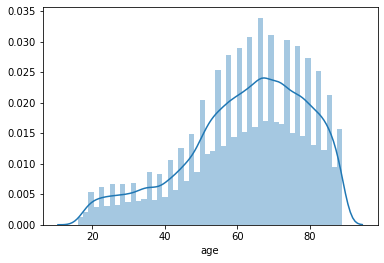

In [130]:
sns.distplot(training['age'].dropna())

## Drop useless fields

In [131]:
#drop these columns

id_columns_to_drop = training.filter(regex='id$',axis=1).columns

In [132]:
training.drop(columns=id_columns_to_drop, inplace=True)

In [133]:
def drop_id_fields(df):
    id_columns_to_drop = df.filter(regex='id$',axis=1).columns
    df.drop(columns=id_columns_to_drop, inplace=True)
    return df

## Missing values

3 Types of Missing values:

1. MCAR Missing completely at random
    - This is generally ok to impute mean, mode or median.
    
The two below must be treated with caution. When there is a dependance with the target and other variables with why it is missing then there may be an improvement if a model is used to impute the missing values.

2. MAR Missing at random
3. MNAR Missing not at random

Columnwise

Text(0, 0.5, 'count of fields')

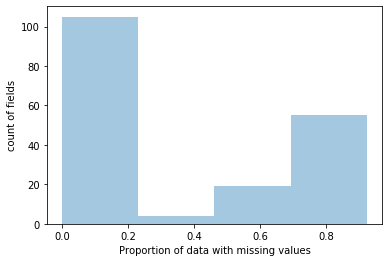

In [134]:
sns.distplot((training.isnull().sum()/training.shape[0]).sort_values(ascending=False), kde=False)

plt.xlabel('Proportion of data with missing values')
plt.ylabel('count of fields')

Text(0, 0.5, 'count of fields')

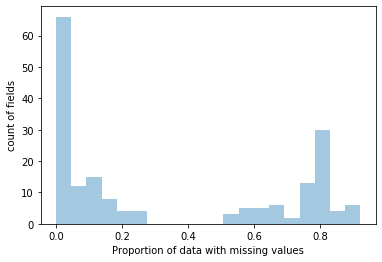

In [135]:
sns.distplot((training.isnull().sum()/training.shape[0]).sort_values(ascending=False), kde=False, bins=20
            )

plt.xlabel('Proportion of data with missing values')
plt.ylabel('count of fields')

Based on the plot below, we have decided to make the cut off for missing values at 40%

In [136]:
list_to_drop = training.columns[(training.isnull().sum()/training.shape[0])>0.1]

In [35]:
training.drop(columns=list_to_drop, inplace=True)

In [36]:
def drop_missing_columns(df):
    list_to_drop = df.columns[(df.isnull().sum()/df.shape[0])>0.1]
    df.drop(columns=list_to_drop, inplace=True)
    return df

In [37]:
training.head()

,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,icu_stay_type,icu_type,...,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,gender_missing
0,0,68.0,22.73,0,Caucasian,M,180.3,Floor,admit,CTICU,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,M
1,0,77.0,27.42,0,Caucasian,F,160.0,Floor,admit,Med-Surg ICU,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,F
2,0,25.0,31.95,0,Caucasian,F,172.7,Accident & Emergency,admit,Med-Surg ICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,F
3,0,81.0,22.64,1,Caucasian,F,165.1,Operating Room / Recovery,admit,CTICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,F
4,0,19.0,NaN,0,Caucasian,M,188.0,Accident & Emergency,admit,Med-Surg ICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,M


Missing values Row-wise

Text(0, 0.5, 'count of rows')

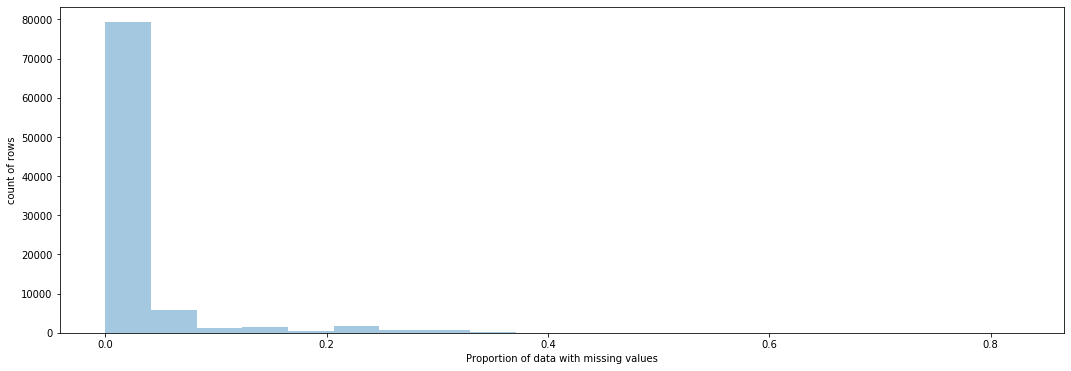

In [38]:
plt.figure(figsize=(18,6))

sns.distplot((training.isnull().sum(axis=1)/training.shape[1]).sort_values(ascending=False), kde=False, bins=20
            )

plt.xlabel('Proportion of data with missing values')
plt.ylabel('count of rows')

In [39]:
training[(training.isnull().sum(axis=1)/training.shape[1])>0.1]

,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,icu_stay_type,icu_type,...,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,gender_missing
4,0,19.0,NaN,0,Caucasian,M,188.0,Accident & Emergency,admit,Med-Surg ICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,M
19,0,39.0,37.010278,1,NaN,M,177.8,Operating Room / Recovery,admit,CTICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,M
46,1,64.0,16.980389,0,Caucasian,M,180.3,Operating Room / Recovery,admit,Neuro ICU,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,Neurological,Neurologic,M
51,0,53.0,NaN,1,Caucasian,F,162.6,Operating Room / Recovery,admit,CTICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Undefined diagnoses,F
52,0,73.0,28.058219,1,Caucasian,M,177.8,Operating Room / Recovery,admit,CTICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91704,0,38.0,32.992923,0,Caucasian,M,177.8,Accident & Emergency,admit,Cardiac ICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,M
91705,0,67.0,28.876843,0,African American,M,182.9,Accident & Emergency,admit,Med-Surg ICU,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,M
91707,0,NaN,33.933518,0,Caucasian,F,152.0,Accident & Emergency,admit,Med-Surg ICU,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F
91710,0,48.0,27.236914,0,Caucasian,M,170.2,Accident & Emergency,admit,Med-Surg ICU,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,M


In [40]:
rows_to_drop = training[(training.isnull().sum(axis=1)/training.shape[1])>0.2].index

In [41]:
training.drop(rows_to_drop, inplace=True)

In [42]:
def drop_missing_rows(df):
    rows_to_drop = df[(df.isnull().sum(axis=1)/df.shape[1])>0.2].index
    df.drop(rows_to_drop, inplace=True)
    return df

In [43]:
import missingno as msno

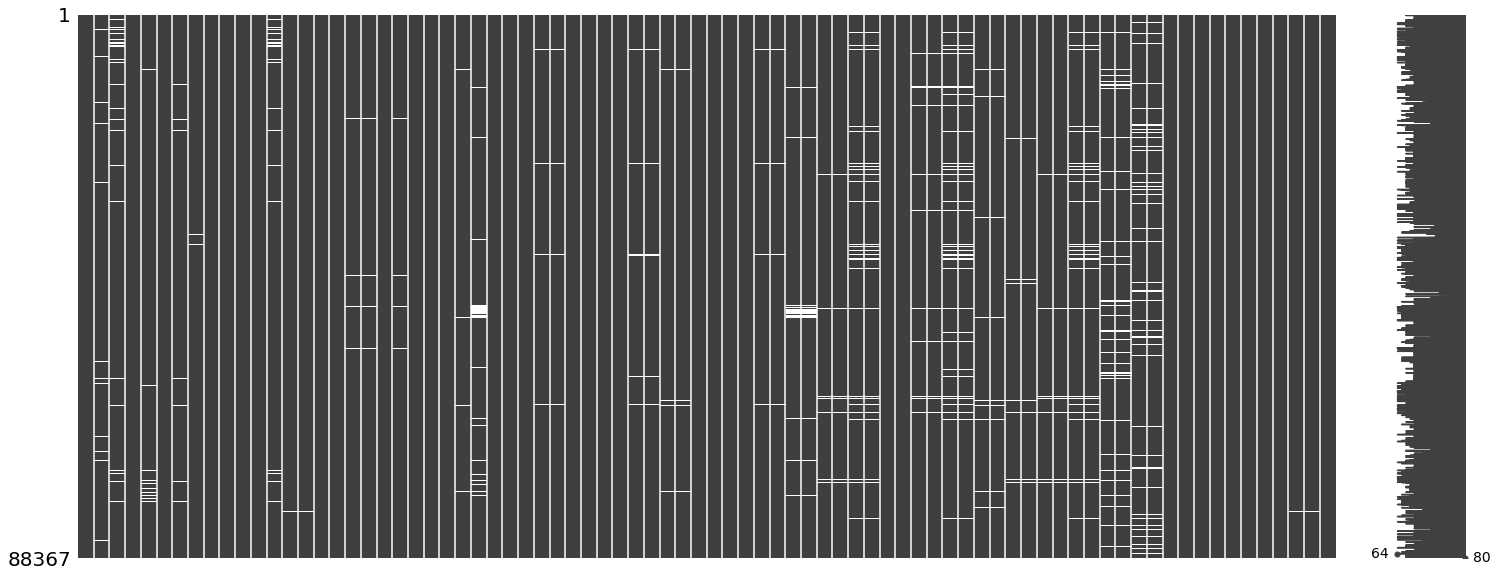

In [44]:
msno.matrix(training)

In [45]:
categorical = training.select_dtypes('object')

In [46]:
numerical = training.select_dtypes(exclude='object')

## fill nas

In [47]:
training.dtypes.value_counts()

float64    68
object      8
int64       4
dtype: int64

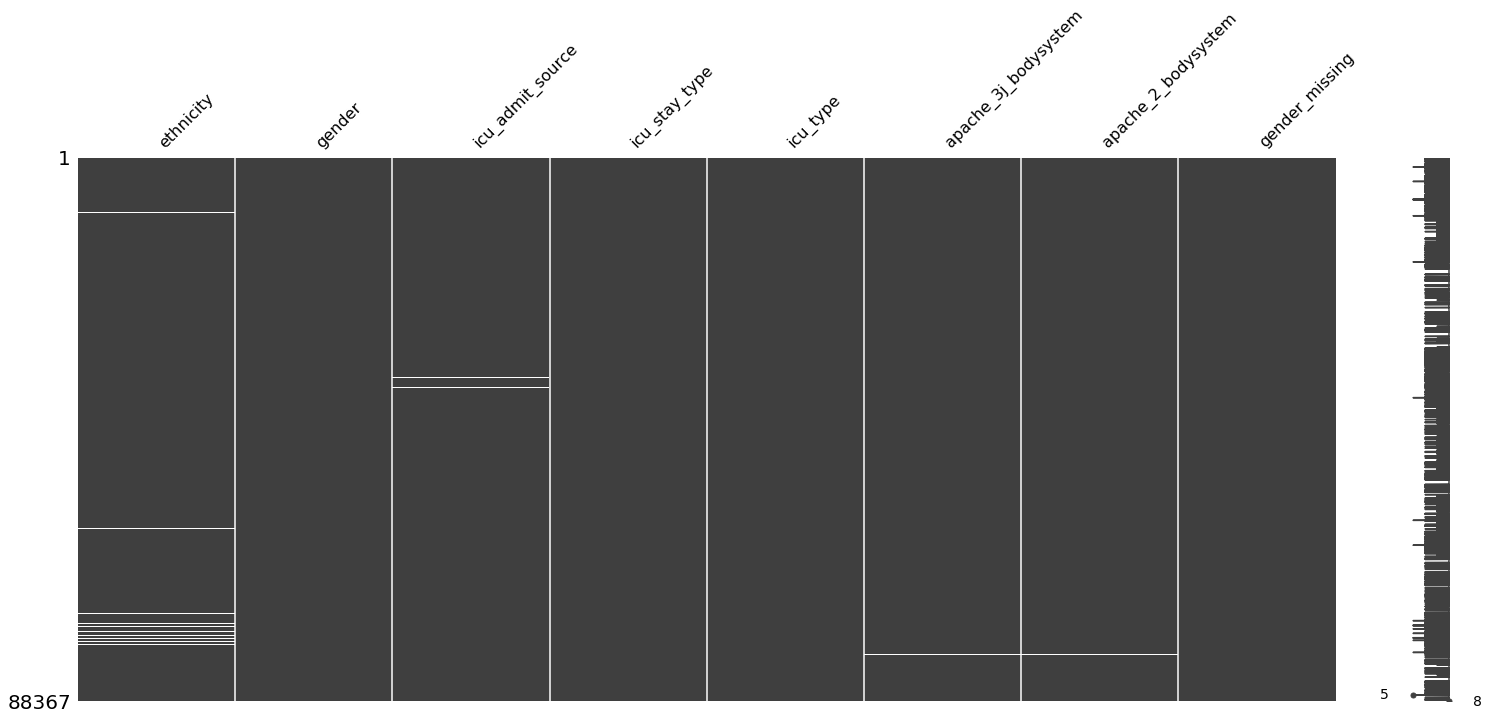

In [48]:
msno.matrix(categorical)

In [49]:
categorical.isnull().sum()

ethnicity               1255
gender                    23
icu_admit_source          95
icu_stay_type              0
icu_type                   0
apache_3j_bodysystem     821
apache_2_bodysystem      821
gender_missing             0
dtype: int64

In [50]:
from sklearn.impute import SimpleImputer

## categorical imputer

cat_imp = SimpleImputer(strategy="most_frequent")

In [51]:
training_backup = training.copy()

In [52]:
training[categorical.columns] = cat_imp.fit_transform(categorical)

In [53]:
training[categorical.columns].isnull().sum()

ethnicity               0
gender                  0
icu_admit_source        0
icu_stay_type           0
icu_type                0
apache_3j_bodysystem    0
apache_2_bodysystem     0
gender_missing          0
dtype: int64

In [54]:
# imputer numerical features

num_imp = SimpleImputer(strategy="mean")

training[numerical.columns] = num_imp.fit_transform(numerical)



In [55]:
training[numerical.columns].isnull().sum()

hospital_death                 0
age                            0
bmi                            0
elective_surgery               0
height                         0
                              ..
hepatic_failure                0
immunosuppression              0
leukemia                       0
lymphoma                       0
solid_tumor_with_metastasis    0
Length: 72, dtype: int64

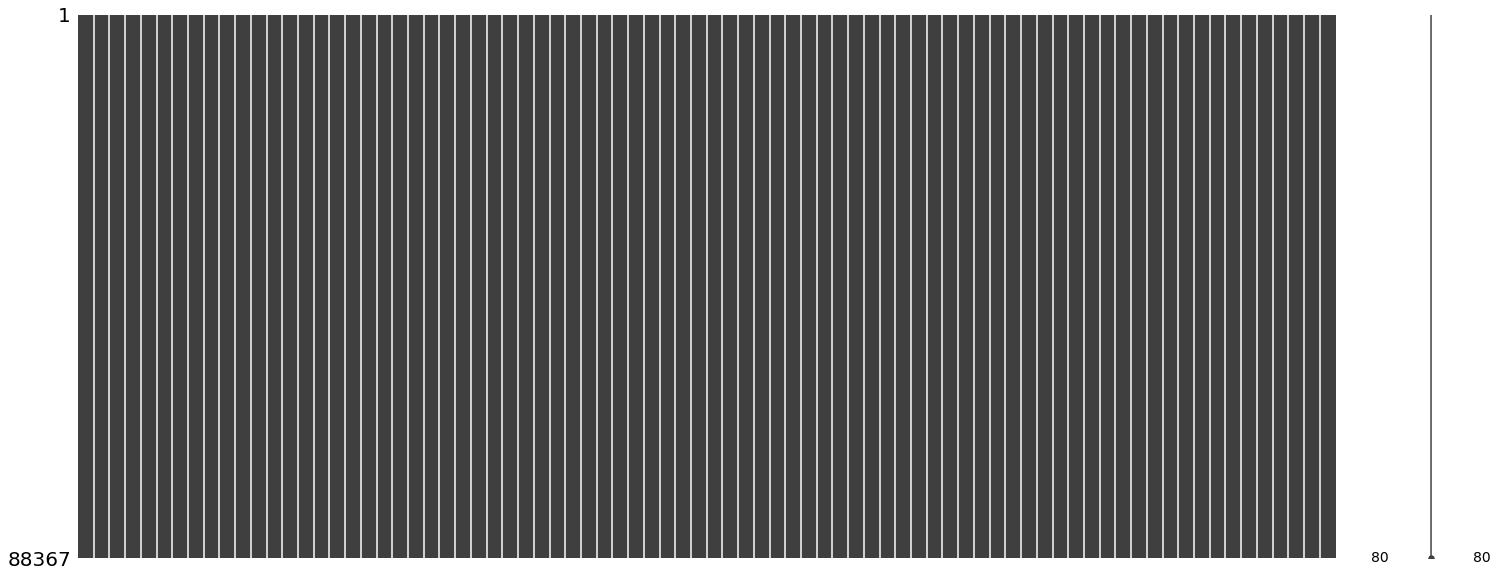

In [56]:
msno.matrix(training)

## Multicollinearity - remove columns that are highly correlated with each other

In [57]:
corr_matrix = training.corr().abs()

In [58]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

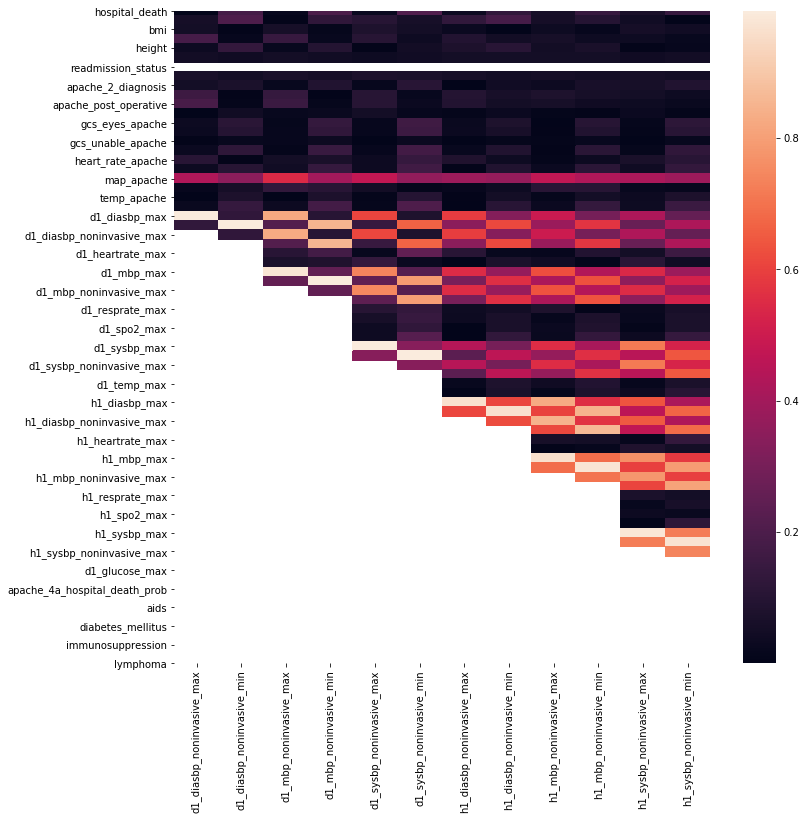

In [59]:
plt.figure(figsize=(12,12))

sns.heatmap(upper[to_drop])

In [60]:
# drop highly correlated features #revisit

# training.drop(columns=to_drop, inplace=True)

## Convert to numerical via labelencoding or onehotencoding #revisit

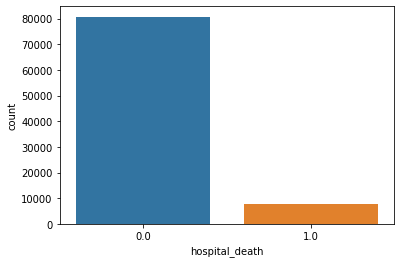

In [62]:
sns.countplot(training.hospital_death)

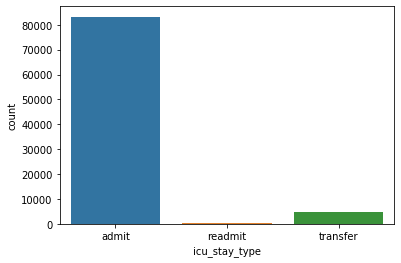

In [63]:
sns.countplot(categorical.icu_stay_type)

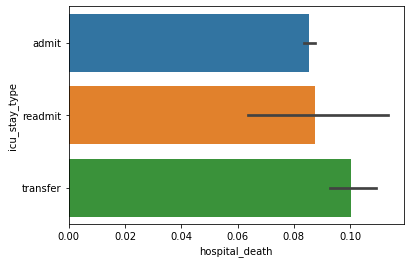

In [64]:
sns.barplot(training.hospital_death, categorical.icu_stay_type)

In [72]:
training_backup = training.copy()

In [74]:
training = training_backup.copy()

## train test split

In [137]:
# load train test split

from sklearn.model_selection import train_test_split

In [138]:
X = training.iloc[:, 1:]

In [139]:
X

,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,...,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,gender_missing
0,68.0,22.730000,0,Caucasian,M,180.3,Floor,Floor,admit,CTICU,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,M
1,77.0,27.420000,0,Caucasian,F,160.0,Floor,Floor,admit,Med-Surg ICU,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,F
2,25.0,31.950000,0,Caucasian,F,172.7,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,F
3,81.0,22.640000,1,Caucasian,F,165.1,Operating Room,Operating Room / Recovery,admit,CTICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,F
4,19.0,NaN,0,Caucasian,M,188.0,NaN,Accident & Emergency,admit,Med-Surg ICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,75.0,23.060250,0,Caucasian,M,177.8,Acute Care/Floor,Floor,admit,Cardiac ICU,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Sepsis,Cardiovascular,M
91709,56.0,47.179671,0,Caucasian,F,183.0,Emergency Department,Floor,admit,Med-Surg ICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,F
91710,48.0,27.236914,0,Caucasian,M,170.2,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,M
91711,NaN,23.297481,0,Caucasian,F,154.9,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,F


In [140]:
y = training.iloc[:, 0]

In [141]:
# convert to categorical features

X = pd.concat([
        X.select_dtypes([], ['object']),
        X.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
        ], axis=1).reindex(X.columns, axis=1)

In [142]:
X

,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,...,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,gender_missing
0,68.0,22.730000,0,Caucasian,M,180.3,Floor,Floor,admit,CTICU,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,M
1,77.0,27.420000,0,Caucasian,F,160.0,Floor,Floor,admit,Med-Surg ICU,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,F
2,25.0,31.950000,0,Caucasian,F,172.7,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,F
3,81.0,22.640000,1,Caucasian,F,165.1,Operating Room,Operating Room / Recovery,admit,CTICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,F
4,19.0,NaN,0,Caucasian,M,188.0,NaN,Accident & Emergency,admit,Med-Surg ICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,75.0,23.060250,0,Caucasian,M,177.8,Acute Care/Floor,Floor,admit,Cardiac ICU,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Sepsis,Cardiovascular,M
91709,56.0,47.179671,0,Caucasian,F,183.0,Emergency Department,Floor,admit,Med-Surg ICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,F
91710,48.0,27.236914,0,Caucasian,M,170.2,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,M
91711,NaN,23.297481,0,Caucasian,F,154.9,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,F


In [143]:
X.dtypes.value_counts().sum()

182

In [144]:
training = training_backup.copy()

## Train Test Split

In [243]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [181]:
Y_train, Y_test = y_train, y_test

In [182]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(73370, 182)
(18343, 182)
(73370,)
(18343,)


## Create Pipeline

In [183]:
# need to undo the previous preprocessing steps

X_train.dtypes.value_counts()

float64     170
int64         3
category      1
category      1
category      1
category      1
category      1
category      1
category      1
category      1
category      1
dtype: int64

In [241]:
## create transformers for pipeline

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## data needs to be at preprocessing stage
# need to undo steps below

# Missing value imputer. Replace NaN with 'missing_value' for categorical fields.
categorical_transformer  = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant')),
                                           ('encoder', OneHotEncoder(handle_unknown='ignore'))])

# Standardise numerical fields
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                                      ('scaler', StandardScaler())])


In [185]:
# create a list of features with specific data types for processing

numeric_features     = X_train.select_dtypes(include=[np.number]).columns
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns


In [244]:
# Assemble categorical and numerical pipelines
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [245]:
preprocessor.fit(X_train)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('num',
                                 Pipeline(memory=None,
                                          steps=[('imputer',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='mean',
                                                                verbose=0)),
                                                 ('scaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                             

In [188]:
# https://stackoverflow.com/questions/10592605/save-classifier-to-disk-in-scikit-learn

from sklearn.externals import joblib

# now you can save it to a file
joblib.dump(preprocessor, 'preprocessor.pkl') 

# and later you can load it
preprocessor_load = joblib.load('preprocessor.pkl') 

In [189]:
X_train.shape

(73370, 182)

In [246]:
preprocessor.transform(X_train).shape

(73370, 242)

In [247]:
X_train.head()

,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,...,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,gender_missing
4609,86.0,28.168975,0,Caucasian,M,170.2,Direct Admit,Accident & Emergency,admit,Neuro ICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic,M
75674,72.0,36.635088,0,Caucasian,M,170.1,NaN,Accident & Emergency,admit,Med-Surg ICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Gastrointestinal,Gastrointestinal,M
84022,36.0,27.459684,0,African American,M,162.6,Emergency Department,Accident & Emergency,admit,MICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,M
38035,60.0,21.977351,0,Caucasian,M,181.0,Emergency Department,Accident & Emergency,admit,MICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Genitourinary,Renal/Genitourinary,M
24371,27.0,19.960244,0,Caucasian,F,177.8,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Sepsis,Cardiovascular,F


In [248]:
X_train_processed = preprocessor.transform(X_train)

In [193]:
X_train_processed_df = pd.DataFrame(X_train_processed)#, columns=X_train.columns.to_list())

In [194]:
X_train_processed_df

,0,1,2,3,4,5,6,7,8,9,...,232,233,234,235,236,237,238,239,240,241
0,1.448557,-0.127551,-0.474986,0.050362,-0.335674,0.0,-0.101486,-2.038076e-15,1.355157,-3.281421e-01,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.593911,0.914818,-0.474986,0.041041,-0.300049,0.0,0.888962,-2.038076e-15,-0.720419,-5.515740e-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-1.603749,-0.214881,-0.474986,-0.658038,-0.317862,0.0,-0.466815,-2.038076e-15,-0.743872,3.117437e-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.138642,-0.889879,-0.474986,1.057036,-0.250229,0.0,-0.491170,-2.038076e-15,1.402062,7.412118e-01,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-2.153164,-1.138231,-0.474986,0.758762,-0.314800,0.0,-0.852440,-9.244760e-01,-0.849410,-1.263788e-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73365,-2.824671,-0.840459,2.105327,-0.425012,-0.334004,0.0,-0.937683,-2.038076e-15,0.393591,2.049159e+00,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
73366,0.471819,0.033288,2.105327,0.963825,-0.111068,0.0,0.462745,-2.038076e-15,0.000000,-1.212608e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
73367,0.593911,0.199749,2.105327,1.616299,-0.240766,0.0,0.962028,-2.038076e-15,0.194242,1.400554e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
73368,-0.993288,3.956434,-0.474986,-0.191985,-0.335674,0.0,3.580219,1.140727e+00,-0.978400,-7.663080e-01,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [249]:
X_train = X_train_processed

In [160]:
clf = Pipeline([
    ('transform', preprocessor),
    ('LGBM', lgb.LGBMClassifier())
])

In [167]:
# Cross validate model with Kfold stratified cross val
kfold = 10
n_jobs = 5
random_state = 42
kf = 1

In [178]:
kf = KFold(n_splits=2, shuffle=True, random_state=44)

cross_val_score(clf, X_train, y_train, cv=kf).mean()

C:\Users\Anthony\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: Specifying the columns using strings is only supported for pandas DataFrames

## Model

In [196]:
from sklearn.ensemble import RandomForestClassifier

randomforest = RandomForestClassifier()

In [197]:
import lightgbm as lgb

In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

In [199]:
import xgboost as xgb

In [209]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)
n_jobs = 8
random_state = 42

In [210]:
# Modeling step Test differents algorithms 
classifiers = []
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(lgb.LGBMClassifier(random_state=random_state))
classifiers.append(xgb.XGBClassifier(random_state=random_state))
# classifiers.append(SVC(random_state=random_state))
# classifiers.append(DecisionTreeClassifier(random_state=random_state))
# classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
# classifiers.append(ExtraTreesClassifier(random_state=random_state))
# classifiers.append(GradientBoostingClassifier(random_state=random_state))
# classifiers.append(MLPClassifier(random_state=random_state))
# classifiers.append(KNeighborsClassifier())
# classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "roc_auc", cv = kfold, n_jobs=n_jobs, verbose=1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:   41.4s remaining:   27.6s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:  1.0min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    6.0s remaining:    4.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:   10.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:   11.8s remaining:    7.8s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:   20.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:  1.9min remaining:  1.3min
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:  3.2min finished


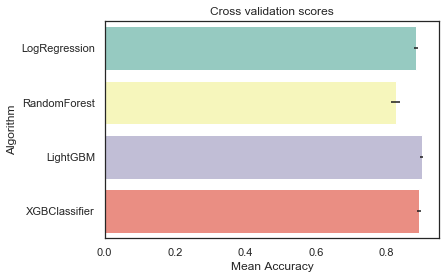

In [211]:
# cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["LogRegression", "SVC","DecisionTree","AdaBoost",
# "RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LinearDiscriminantAnalysis"]})

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["LogRegression", "RandomForest", "LightGBM", "XGBClassifier"]})


g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
# g.set_xlabel("Mean Accuracy")
# g = g.set_title("Cross validation scores")
    
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [212]:
cv_res.sort_values('CrossValMeans', ascending=False)

,CrossValMeans,CrossValerrors,Algorithm
2,0.898793,0.005545,LightGBM
3,0.892053,0.005374,XGBClassifier
0,0.882539,0.005709,LogRegression
1,0.825274,0.012517,RandomForest


In [213]:
# LGBM Parameters tunning 
LGBM = lgb.LGBMClassifier()


## Search grid for optimal parameters
LGBM_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsLGBM = GridSearchCV(LGBM, param_grid = LGBM_param_grid, cv=kfold, scoring="roc_auc", n_jobs=n_jobs, verbose = 1)

In [214]:
gsLGBM.fit(X_train,y_train)

LGBM_best = gsLGBM.best_estimator_

# Best score
gsLGBM.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.4min
C:\Users\Anthony\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  7.4min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed: 17.1min
[Parallel(n_jobs=8)]: Done 540 out of 540 | elapsed: 21.2min finished


0.8988894411870775

In [215]:
# save it to a file
joblib.dump(gsLGBM, 'gsLGBM.pkl') 

# and later you can load it
# preprocessor_load = joblib.load('gsLGBM.pkl') 

joblib.dump(gsLGBM.best_estimator_, 'gsLGBM.best_estimator_.pkl') 

# and later you can load it
# preprocessor_load = joblib.load('gsLGBM.best_estimator_.pkl') 

['gsLGBM.best_estimator_.pkl']

In [264]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC, param_grid = rf_param_grid, cv=kfold, scoring="roc_auc", n_jobs=n_jobs, verbose = 1)

gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  8.1min
C:\Users\Anthony\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed: 41.9min
[Parallel(n_jobs=8)]: Done 540 out of 540 | elapsed: 71.7min finished


0.8945533181390115

In [265]:
# save it to a file
joblib.dump(gsRFC, 'gsRFC.pkl') 

# and later you can load it
# preprocessor_load = joblib.load('gsLGBM.pkl') 

joblib.dump(gsRFC.best_estimator_, 'gsRFC.best_estimator_.pkl') 

# and later you can load it
# preprocessor_load = joblib.load('gsLGBM.best_estimator_.pkl') 

['gsRFC.best_estimator_.pkl']

In [266]:
# XGBC Parameters tunning 

XGBC = xgb.XGBClassifier()


## Search grid for optimal parameters
XGBC_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsXGBC = GridSearchCV(XGBC, param_grid = XGBC_param_grid, cv=kfold, scoring="roc_auc", n_jobs=n_jobs, verbose = 1)

gsXGBC.fit(X_train,y_train)

XGBC_best = gsXGBC.best_estimator_

# Best score
gsXGBC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed: 20.1min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed: 89.4min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed: 211.0min
[Parallel(n_jobs=8)]: Done 540 out of 540 | elapsed: 261.0min finished


0.8920527842251131

In [267]:
# save it to a file
joblib.dump(gsXGBC, 'gsXGBC.pkl') 

# and later you can load it
# preprocessor_load = joblib.load('gsLGBM.pkl') 

joblib.dump(gsXGBC.best_estimator_, 'gsXGBC.best_estimator_.pkl') 

# and later you can load it
# preprocessor_load = joblib.load('gsLGBM.best_estimator_.pkl') 

['gsXGBC.best_estimator_.pkl']

Wall time: 0 ns


KeyboardInterrupt: 

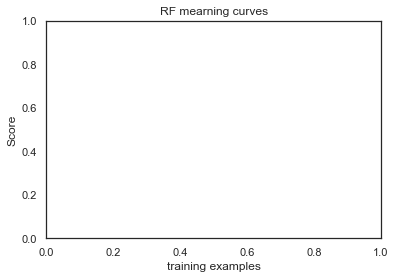

In [269]:
%time

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,y_train,cv=kfold)
# g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,y_train,cv=kfold)
# g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,y_train,cv=kfold)
# g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,y_train,cv=kfold)
# g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsLGBM.best_estimator_, "LGBM mearning curves", X_train, y_train, cv=kfold)
g = plot_learning_curve(gsXGBC.best_estimator_,"XGBC mearning curves",X_train,y_train,cv=kfold)


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

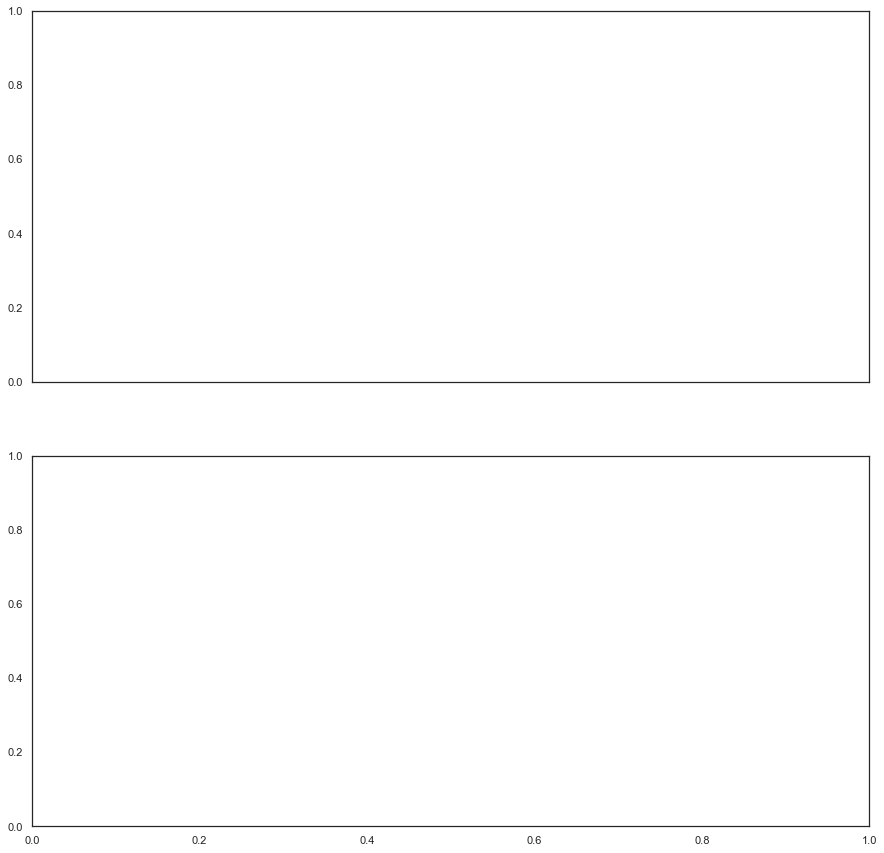

In [219]:
# nrows = 1
# ncols = 1

nrows = 2
ncols = 1

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

# names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]
# names_classifiers = [("RandomForest", RFC_best), ("LightGBM", LGBM_best)]
names_classifiers = [("LightGBM", LGBM_best)]

nclassifier = 0

for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:20]
        g = sns.barplot(y=X_train.columns[indices][:20],x = classifier.feature_importances_[indices][:20] , orient='h', ax=axes[row])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1
        
        

In [ ]:
names_classifiers = [("RandomForest", RFC_best), ("LightGBM", LGBM_best), ("XGBC", XGBC_best)]

nclassifier = 0

names_classifiers[nclassifier][0]


In [ ]:
names_classifiers[nclassifier][1]


In [ ]:
nclassifier = 1

names_classifiers[nclassifier][0]

In [ ]:
names_classifiers[nclassifier][1]

In [ ]:
axes[0]

In [220]:
name = names_classifiers[0][0]
classifier = names_classifiers[0][1]
indices = np.argsort(classifier.feature_importances_)[::-1][:20]
g = sns.barplot(y=X_train.columns[indices][:20],x = classifier.feature_importances_[indices][:20] , orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title(name + " feature importance")
nclassifier += 1

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
name = names_classifiers[1][0]
classifier = names_classifiers[1][1]
indices = np.argsort(classifier.feature_importances_)[::-1][:20]
g = sns.barplot(y=X_train.columns[indices][:20],x = classifier.feature_importances_[indices][:20] , orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title(name + " feature importance")
nclassifier += 1

In [ ]:
name = names_classifiers[2][0]
classifier = names_classifiers[2][1]
indices = np.argsort(classifier.feature_importances_)[::-1][:20]
g = sns.barplot(y=X_train.columns[indices][:20],x = classifier.feature_importances_[indices][:20] , orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title(name + " feature importance")
nclassifier += 1

In [ ]:
# Need to align test set with train

In [ ]:
X_train.columns.to_list()

apply all preprocesing steps to test data frame

drop id fields
drop missing columns
drop missing rows
fill nas / impute missing values
- categorical, mode
- numerical, mean
multicollinearity threshold > 0.95
one hot encode categorical fields
scale all day except for target label



In [226]:
training

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.730000,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.420000,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.950000,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.640000,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,91592,78108,30,0,75.0,23.060250,0,Caucasian,M,177.8,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Sepsis,Cardiovascular
91709,66119,13486,121,0,56.0,47.179671,0,Caucasian,F,183.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
91710,8981,58179,195,0,48.0,27.236914,0,Caucasian,M,170.2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
91711,33776,120598,66,0,NaN,23.297481,0,Caucasian,F,154.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory


In [240]:
training.select_dtypes('object').melt().groupby(['variable', 'value']).size()

variable               value                    
apache_2_bodysystem    Cardiovascular               38816
                       Gastrointestinal              9026
                       Haematologic                   638
                       Metabolic                     7650
                       Neurologic                   11896
                       Renal/Genitourinary           2460
                       Respiratory                  11609
                       Trauma                        3842
                       Undefined Diagnoses            346
                       Undefined diagnoses           3768
apache_3j_bodysystem   Cardiovascular               29999
                       Gastrointestinal              9026
                       Genitourinary                 2172
                       Gynecological                  313
                       Hematological                  638
                       Metabolic                     7650
                       

In [239]:
unlabeled.select_dtypes('object').melt().groupby(['variable', 'value']).size()

variable               value                    
apache_2_bodysystem    Cardiovascular               14829
                       Gastrointestinal              3949
                       Haematologic                   192
                       Metabolic                     3101
                       Neurologic                    5989
                       Renal/Genitourinary            932
                       Respiratory                   5284
                       Trauma                        2395
                       Undefined Diagnoses            141
                       Undefined diagnoses           1600
apache_3j_bodysystem   Cardiovascular               11393
                       Gastrointestinal              3949
                       Genitourinary                  820
                       Gynecological                  124
                       Hematological                  192
                       Metabolic                     3101
                       

In [250]:
test = preprocessor.transform(unlabeled)

C:\Users\Anthony\Anaconda3\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


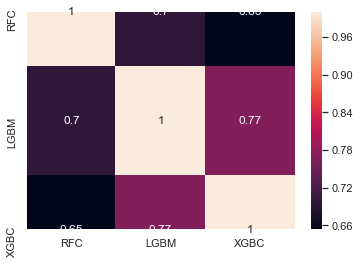

In [270]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
# test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
# test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
# test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
# test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")
test_Survived_LGBM = pd.Series(LGBM_best.predict(test), name="LGBM")
test_Survived_XGBC = pd.Series(XGBC_best.predict(test), name="XGBC")


# Concatenate all classifier results
# ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)

ensemble_results = pd.concat([test_Survived_RFC, test_Survived_LGBM, test_Survived_XGBC],axis=1)
# ensemble_results = pd.concat([test_Survived_LGBM],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

In [271]:
# votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
# ('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

# votingC = VotingClassifier(estimators=[('lgbmc', LGBM_best)],  voting='soft', n_jobs=4)
votingC = VotingClassifier(estimators=[('lgbmc', LGBM_best),('rfc', RFC_best),('xgbc', XGBC_best)],  voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, y_train)

In [272]:
test_Survived = pd.Series(votingC.predict(test), name="hospital_death")

results = pd.concat([unlabeled['encounter_id'], test_Survived],axis=1)

results.to_csv("ensemble_python_voting1.csv", index=False)

In [262]:
end_time = datetime.now()

In [263]:
print(end_time - start_time)

1:47:50.400566
